# EECS 731 Project 5: Time Series Forecasting

## by Matthew Taylor

### Import required modules

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
register_matplotlib_converters()

### Import product demand dataset

In [2]:
df = pd.read_csv('data/product_demand.csv')
df = df.dropna()
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


### Find products with the most available information

In [3]:
df['Product_Code'].value_counts()[:3]

Product_1359    16936
Product_1295    10575
Product_1378     9770
Name: Product_Code, dtype: int64

### Remove unnecessary data

In [4]:
# For this project, I chose Product_1359
df = df.loc[df['Product_Code'] == 'Product_1359']
df = df.drop(columns=['Product_Code', 'Warehouse', 'Product_Category'])
df = df.sort_values(by=['Date'])
df = df.reset_index(drop=True)
df.head()

,Date,Order_Demand
0,2012/1/10,50000
1,2012/1/10,25000
2,2012/1/10,1000
3,2012/1/10,2000
4,2012/1/10,1000


### Group demand values by month

In [5]:
# Doing this not only reduces the number of entries
# the forecasting models will need to process,
# it also gives a uniform temporal distribution

dates = []
demands = []

for i in range(2012, 2017):
    for j in range(1, 13):
        dates.append(datetime(i, j, 1))

temp_total = 0
current_year = 2012
current_month = 1

for index, row in df.iterrows():
    ymd = row['Date'].split('/')
    y = int(ymd[0])
    m = int(ymd[1])
    demand = int(row['Order_Demand'].strip('()'))
    
    if y == current_year and m == current_month:
        temp_total += demand
    else:
        demands.append(temp_total)
        temp_total = demand
        current_year = y
        current_month = m

df = pd.DataFrame(list(zip(dates, demands)), columns=['Date', 'Demand'])
df.head()

,Date,Demand
0,2012-01-01,8911000
1,2012-02-01,7685000
2,2012-03-01,7894000
3,2012-04-01,8302000
4,2012-05-01,8131000


### Split data into training and testing subsets

In [6]:
# Removing the shuffle feature is required when
# performing the train-test split on time-series data

x = df.Date.values
y = df.Demand.values
train_input, test_input, train_output, test_output = train_test_split(x, y, test_size=.2, shuffle=False)

### Moving average forecasting

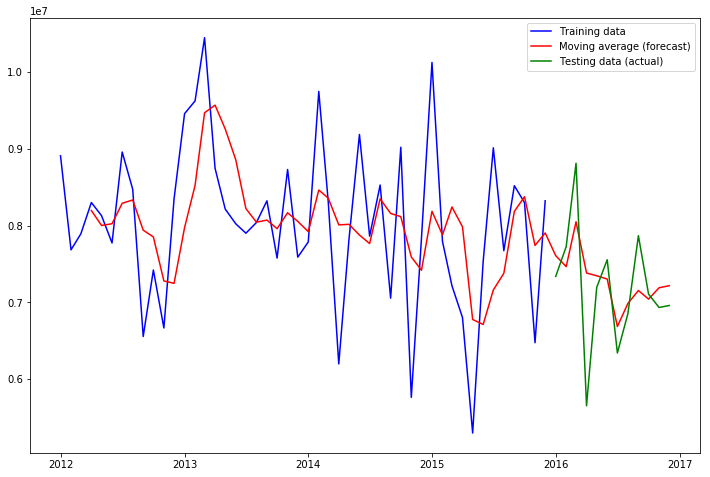

In [7]:
# Plot gives simple qualitative accuracy

moving_average = df.set_index('Date').rolling(4).mean()
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(train_input, train_output, color='blue', label='Training data')
plt.plot(moving_average, color='red', label='Moving average (forecast)')
plt.plot(test_input, test_output, color='green', label='Testing data (actual)')
plt.legend(loc='best')
plt.show()

In [8]:
# R-Squared value gives this model a quantitative accuracy

r2_score(test_output, list(moving_average['Demand'][-12:]))

0.33171629110700274

### ARIMA forecasting

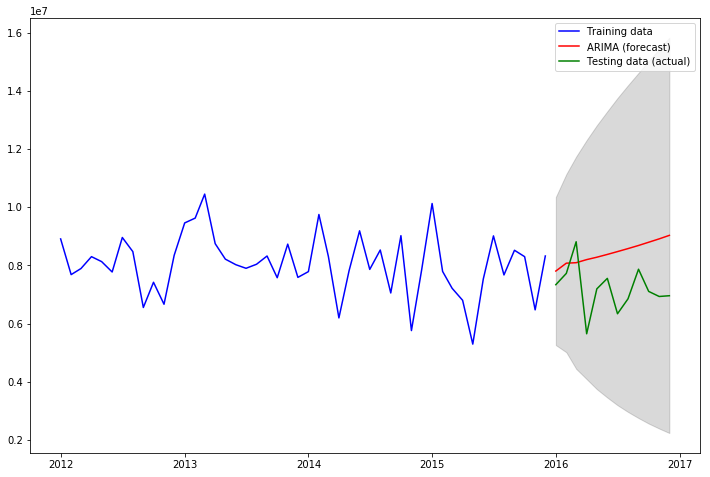

In [9]:
# Use same illustration to show qualitative accuracy

model = ARIMA(train_output, order=(1, 2, 1))
model_fit = model.fit()

forecast, se, conf = model_fit.forecast(12, alpha=0.05)

lower_bound = conf[:, 0]
upper_bound = conf[:, 1]

plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(train_input, train_output, color='blue', label='Training data')
plt.plot(test_input, forecast, color='red', label='ARIMA (forecast)')
plt.plot(test_input, test_output, color='green', label='Testing data (actual)')
plt.fill_between(test_input, lower_bound, upper_bound, color='black', alpha=0.15)
plt.legend(loc='best')

plt.show()

In [10]:
# Quantitative ARIMA accuracy

r2_score(test_output, forecast)

-3.1470816862389634